# Convolutional Autoencoder Final Training and Evaluation

This notebook trains Convolutional Autoencoder with the best hyperparameters found during tuning and evaluates on the test set.

**Task**: Binary anomaly detection (normal vs fault)

**Data Split**:
- Train (normal only): Model fitting
- Validation (normal only): Early stopping monitoring (reconstruction loss)
- Test (mixed): Final evaluation (never seen during training)

**Architecture**: 1D CNN encoder-decoder with optional Transformer layer. Trained on normal data only, anomalies detected by high reconstruction error.

**Outputs**:
- Trained model: `outputs/models/conv_autoencoder_final.pt`
- Metrics: `outputs/metrics/conv_autoencoder_metrics.json`
- Confusion matrix: `outputs/figures/conv_autoencoder_confusion_matrix.png`

## Configuration

In [1]:
import os
import sys
import time
import json
import pickle
from pathlib import Path

start_time = time.time()

# Quick mode configuration
QUICK_MODE = os.getenv('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
HYPERPARAM_DIR = OUTPUT_DIR / 'hyperparams'
MODEL_DIR = OUTPUT_DIR / 'models'
METRICS_DIR = OUTPUT_DIR / 'metrics'
FIGURES_DIR = OUTPUT_DIR / 'figures'

# Create output directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
MODE_SUFFIX = '_quick' if QUICK_MODE else ''

# Setup progress logging
LOG_FILE = OUTPUT_DIR / f'conv_autoencoder_final_progress{MODE_SUFFIX}.log'

def log(msg):
    """Log message to both stdout and file."""
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    full_msg = f"[{timestamp}] {msg}"
    print(full_msg)
    with open(LOG_FILE, 'a') as f:
        f.write(full_msg + '\n')

# Clear log file at start
with open(LOG_FILE, 'w') as f:
    f.write('')

log("="*60)
log("Convolutional Autoencoder Final Training and Evaluation")
log("="*60)

if QUICK_MODE:
    TRAIN_FRACTION = 0.01
    MAX_EPOCHS = 1
    PATIENCE = 1
    log("🚀 QUICK MODE (1% data, 1 epoch)")
else:
    TRAIN_FRACTION = 1.0
    MAX_EPOCHS = 100
    PATIENCE = 10
    log("🔬 FULL MODE (100% data, up to 100 epochs)")

# Load best hyperparameters (prefer full mode, fall back to quick)
if (HYPERPARAM_DIR / 'conv_autoencoder_best.json').exists():
    hp_file = HYPERPARAM_DIR / 'conv_autoencoder_best.json'
    log("Using FULL mode hyperparameters")
else:
    hp_file = HYPERPARAM_DIR / 'conv_autoencoder_best_quick.json'
    log("Using QUICK mode hyperparameters")

with open(hp_file) as f:
    hp_data = json.load(f)
    best_params = hp_data['best_params']

log(f"Hyperparameters: {best_params}")
log("="*60)

[2026-01-05 14:22:47] ============================================================
[2026-01-05 14:22:47] Convolutional Autoencoder Final Training and Evaluation
[2026-01-05 14:22:47] ============================================================
[2026-01-05 14:22:47] 🔬 FULL MODE (100% data, up to 100 epochs)
[2026-01-05 14:22:47] Using FULL mode hyperparameters
[2026-01-05 14:22:47] Hyperparameters: {'sequence_length': 40, 'conv_filters': 64, 'kernel_size': 3, 'latent_filters': 128, 'use_transformer': False, 'dropout': 0.11928321723176455, 'learning_rate': 0.00853432554832179, 'batch_size': 128, 'threshold_percentile': 98.65427130589171}
[2026-01-05 14:22:47] ============================================================


## Imports

In [2]:
print("\n[Step 1/6] Loading libraries...")
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f"✓ Using device: {device}")


[Step 1/6] Loading libraries...


[2026-01-05 14:22:51] ✓ Using device: cuda


## Data Loading

In [3]:
print("\n[Step 2/6] Loading datasets...")
data_load_start = time.time()

# Binary dataset: train/val contain only normal data, test contains both
train = pd.read_csv(DATA_DIR / 'binary_train.csv')
val = pd.read_csv(DATA_DIR / 'binary_val.csv')
test = pd.read_csv(DATA_DIR / 'binary_test.csv')

log(f"✓ Train (normal only): {train.shape}")
log(f"✓ Val (normal only): {val.shape}")
log(f"✓ Test (mixed): {test.shape}")
log(f"✓ Data loading time: {time.time() - data_load_start:.2f}s")


[Step 2/6] Loading datasets...


[2026-01-05 14:22:54] ✓ Train (normal only): (50000, 57)
[2026-01-05 14:22:54] ✓ Val (normal only): (25000, 57)
[2026-01-05 14:22:54] ✓ Test (mixed): (795200, 57)
[2026-01-05 14:22:54] ✓ Data loading time: 3.10s


In [4]:
print("\n[Step 3/6] Preparing features and labels...")

# Extract features
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
num_features = len(features)
log(f"✓ Number of features: {num_features}")

# Subsample if in quick mode (subsample runs, not random rows, to preserve sequences)
if TRAIN_FRACTION < 1.0:
    train_runs = train[['faultNumber', 'simulationRun']].drop_duplicates()
    val_runs = val[['faultNumber', 'simulationRun']].drop_duplicates()
    
    n_train_runs = max(1, int(len(train_runs) * TRAIN_FRACTION))
    n_val_runs = max(1, int(len(val_runs) * TRAIN_FRACTION))
    
    sampled_train_runs = train_runs.sample(n=n_train_runs, random_state=RANDOM_SEED)
    sampled_val_runs = val_runs.sample(n=n_val_runs, random_state=RANDOM_SEED)
    
    train = train.merge(sampled_train_runs, on=['faultNumber', 'simulationRun'])
    val = val.merge(sampled_val_runs, on=['faultNumber', 'simulationRun'])
    
    log(f"✓ Subsampled train to {TRAIN_FRACTION*100:.1f}%: {train.shape}")
    log(f"✓ Subsampled val to {TRAIN_FRACTION*100:.1f}%: {val.shape}")

# Create binary labels for test set (0=normal, 1=fault)
test['label'] = (test['faultNumber'] != 0).astype(int)
n_normal = (test['label'] == 0).sum()
n_fault = (test['label'] == 1).sum()
log(f"✓ Test set - Normal: {n_normal}, Fault: {n_fault}")
log(f"✓ Test fault rate: {test['label'].mean():.2%}")

# Standardize features (fit on training data only)
log("✓ Standardizing features (fit on train only)...")
scaler = StandardScaler()
scaler.fit(train[features])


[Step 3/6] Preparing features and labels...
[2026-01-05 14:22:54] ✓ Number of features: 52
[2026-01-05 14:22:54] ✓ Test set - Normal: 115200, Fault: 680000
[2026-01-05 14:22:54] ✓ Test fault rate: 85.51%
[2026-01-05 14:22:54] ✓ Standardizing features (fit on train only)...


,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


## Model Definition

In [5]:
class SimulationRunDataset(Dataset):
    """Dataset for autoencoder - creates windows WITHIN simulation runs only."""
    def __init__(self, df, features, scaler, sequence_length=10):
        self.seq_len = sequence_length
        self.windows = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = scaler.transform(group[features].values)
            
            for i in range(len(X) - sequence_length + 1):
                self.windows.append(X[i:i+sequence_length])
        
        self.windows = np.array(self.windows, dtype=np.float32)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.windows[idx])


class LabeledSimulationRunDataset(Dataset):
    """Dataset with labels for evaluation."""
    def __init__(self, df, features, scaler, sequence_length=10):
        self.seq_len = sequence_length
        self.windows = []
        self.labels = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = scaler.transform(group[features].values)
            y = group['label'].values
            
            for i in range(len(X) - sequence_length + 1):
                self.windows.append(X[i:i+sequence_length])
                self.labels.append(y[i+sequence_length-1])
        
        self.windows = np.array(self.windows, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.windows[idx]), torch.tensor(self.labels[idx])

log("✓ Dataset classes defined")

[2026-01-05 14:22:54] ✓ Dataset classes defined


In [6]:
class ConvAutoencoder(nn.Module):
    """Convolutional Autoencoder with optional Transformer layer."""
    def __init__(self, input_dim, seq_len, conv_filters=64, kernel_size=3,
                 latent_filters=128, nhead=4, ff_dim=32, dropout=0.05,
                 use_transformer=True):
        super().__init__()
        self.use_transformer = use_transformer
        
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, conv_filters, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(conv_filters, latent_filters, kernel_size, padding=kernel_size//2),
            nn.ReLU()
        )
        
        if use_transformer:
            self.transformer_layer = nn.TransformerEncoderLayer(
                d_model=latent_filters, nhead=nhead, 
                dim_feedforward=ff_dim, dropout=dropout, batch_first=True
            )
            self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=1)
        
        self.decoder = nn.Sequential(
            nn.Conv1d(latent_filters, conv_filters, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(conv_filters, input_dim, kernel_size, padding=kernel_size//2)
        )
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.encoder(x)
        
        if self.use_transformer:
            x = x.permute(0, 2, 1)  # (batch, seq_len, features)
            x = self.transformer(x)
            x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        
        x = self.decoder(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        return x

log("✓ Convolutional Autoencoder model defined")

[2026-01-05 14:22:54] ✓ Convolutional Autoencoder model defined


## Model Training

In [7]:
print("\n[Step 4/6] Creating datasets...")

sequence_length = best_params['sequence_length']
batch_size = best_params['batch_size']

# Create separate datasets for train, val, and test
train_dataset = SimulationRunDataset(train, features, scaler, sequence_length)
val_dataset = SimulationRunDataset(val, features, scaler, sequence_length)
test_dataset = LabeledSimulationRunDataset(test, features, scaler, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

log(f"✓ Sequence length: {sequence_length}")
log(f"✓ Batch size: {batch_size}")
log(f"✓ Training windows: {len(train_dataset)}")
log(f"✓ Validation windows: {len(val_dataset)}")
log(f"✓ Test windows: {len(test_dataset)}")


[Step 4/6] Creating datasets...


[2026-01-05 14:22:57] ✓ Sequence length: 40
[2026-01-05 14:22:57] ✓ Batch size: 128
[2026-01-05 14:22:57] ✓ Training windows: 46100
[2026-01-05 14:22:57] ✓ Validation windows: 23050
[2026-01-05 14:22:57] ✓ Test windows: 757370


In [8]:
print("\n[Step 5/6] Training final model with early stopping on validation set...")
train_start = time.time()

# Extract hyperparameters
conv_filters = best_params['conv_filters']
kernel_size = best_params['kernel_size']
latent_filters = best_params['latent_filters']
use_transformer = best_params['use_transformer']
dropout = best_params['dropout']
learning_rate = best_params['learning_rate']

# Handle transformer-specific params
if use_transformer:
    nhead = best_params.get('nhead', 4)
    ff_dim = best_params.get('ff_dim', 32)
    # Ensure latent_filters is divisible by nhead
    latent_filters = (latent_filters // nhead) * nhead
else:
    nhead = 4
    ff_dim = 32
    latent_filters = (latent_filters // 4) * 4

# Build model with best hyperparameters
model = ConvAutoencoder(
    input_dim=num_features,
    seq_len=sequence_length,
    conv_filters=conv_filters,
    kernel_size=kernel_size,
    latent_filters=latent_filters,
    nhead=nhead,
    ff_dim=ff_dim,
    dropout=dropout,
    use_transformer=use_transformer
).to(device)

log(f"✓ Model configuration:")
print(f"  - Conv filters: {conv_filters}")
print(f"  - Kernel size: {kernel_size}")
print(f"  - Latent filters: {latent_filters}")
print(f"  - Use transformer: {use_transformer}")
if use_transformer:
    print(f"  - Transformer heads: {nhead}")
    print(f"  - Feedforward dim: {ff_dim}")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training with early stopping on validation loss
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'epoch': []}

log(f"Training for up to {MAX_EPOCHS} epochs with patience {PATIENCE}...")

for epoch in range(MAX_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch in train_loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        reconstruction = model(X_batch)
        loss = criterion(reconstruction, X_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            reconstruction = model(X_batch)
            loss = criterion(reconstruction, X_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['epoch'].append(epoch + 1)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        log(f"  Epoch {epoch+1}/{MAX_EPOCHS}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
    
    # Early stopping on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"  Early stopping at epoch {epoch+1}")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

train_time = time.time() - train_start
best_epoch = history['epoch'][history['val_loss'].index(min(history['val_loss']))]
print(f"\n✓ Training complete in {train_time:.2f}s ({epoch+1} epochs)")
log(f"✓ Best epoch: {best_epoch} (val_loss = {best_val_loss:.6f})")


[Step 5/6] Training final model with early stopping on validation set...
[2026-01-05 14:22:57] ✓ Model configuration:
  - Conv filters: 64
  - Kernel size: 3
  - Latent filters: 128
  - Use transformer: False


[2026-01-05 14:22:58] Training for up to 100 epochs with patience 10...


[2026-01-05 14:23:01]   Epoch 1/100: Train Loss = 0.333872, Val Loss = 0.212545


[2026-01-05 14:23:22]   Epoch 10/100: Train Loss = 0.052680, Val Loss = 0.026238


[2026-01-05 14:23:51]   Epoch 20/100: Train Loss = 0.031890, Val Loss = 0.036521


  Early stopping at epoch 21

✓ Training complete in 56.46s (21 epochs)
[2026-01-05 14:23:53] ✓ Best epoch: 11 (val_loss = 0.017534)


## Determine Anomaly Threshold

In [9]:
print("\nComputing reconstruction errors on training data...")

model.eval()
train_errors = []

with torch.no_grad():
    for X_batch in train_loader:
        X_batch = X_batch.to(device)
        reconstruction = model(X_batch)
        errors = ((reconstruction - X_batch) ** 2).mean(dim=(1, 2))
        train_errors.extend(errors.cpu().numpy())

train_errors = np.array(train_errors)

# Use threshold percentile from hyperparameter tuning
threshold_percentile = best_params['threshold_percentile']
threshold = np.percentile(train_errors, threshold_percentile)

log(f"✓ Threshold percentile: {threshold_percentile:.1f}%")
log(f"✓ Threshold value: {threshold:.6f}")
log(f"✓ Training error stats - Mean: {train_errors.mean():.6f}, Std: {train_errors.std():.6f}")


Computing reconstruction errors on training data...


[2026-01-05 14:23:55] ✓ Threshold percentile: 98.7%
[2026-01-05 14:23:55] ✓ Threshold value: 0.023038
[2026-01-05 14:23:55] ✓ Training error stats - Mean: 0.017274, Std: 0.002225


## Evaluation on Test Set

In [10]:
print("\n[Step 6/6] Evaluating on test set...")

all_errors = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        reconstruction = model(X_batch)
        errors = ((reconstruction - X_batch) ** 2).mean(dim=(1, 2))
        all_errors.extend(errors.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_errors = np.array(all_errors)
all_labels = np.array(all_labels)

# Make predictions based on threshold
y_pred = (all_errors > threshold).astype(int)
y_test = all_labels

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_binary = f1_score(y_test, y_pred, average='binary')  # F1 for fault class
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# ROC-AUC using reconstruction error as anomaly score
roc_auc = roc_auc_score(y_test, all_errors)

# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, all_errors)
pr_auc = auc(recall_curve, precision_curve)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS (Binary Anomaly Detection) {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"F1 (weighted):     {f1_weighted:.4f}")
print(f"F1 (binary/fault): {f1_binary:.4f}")
print(f"Precision (fault): {precision:.4f}")
print(f"Recall (fault):    {recall:.4f}")
print(f"ROC-AUC:           {roc_auc:.4f}")
print(f"PR-AUC:            {pr_auc:.4f}")
print(f"{'='*60}")


[Step 6/6] Evaluating on test set...



TEST SET RESULTS (Binary Anomaly Detection) 
Accuracy:          0.9939 (99.39%)
Balanced Accuracy: 0.9863 (98.63%)
F1 (weighted):     0.9939
F1 (binary/fault): 0.9964
Precision (fault): 0.9958
Recall (fault):    0.9970
ROC-AUC:           0.9988
PR-AUC:            0.9998


In [11]:
# Per-class metrics
class_names = ['Normal', 'Fault']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9825    0.9757    0.9791    110520
       Fault     0.9958    0.9970    0.9964    646850

    accuracy                         0.9939    757370
   macro avg     0.9892    0.9863    0.9877    757370
weighted avg     0.9939    0.9939    0.9939    757370



## Visualizations

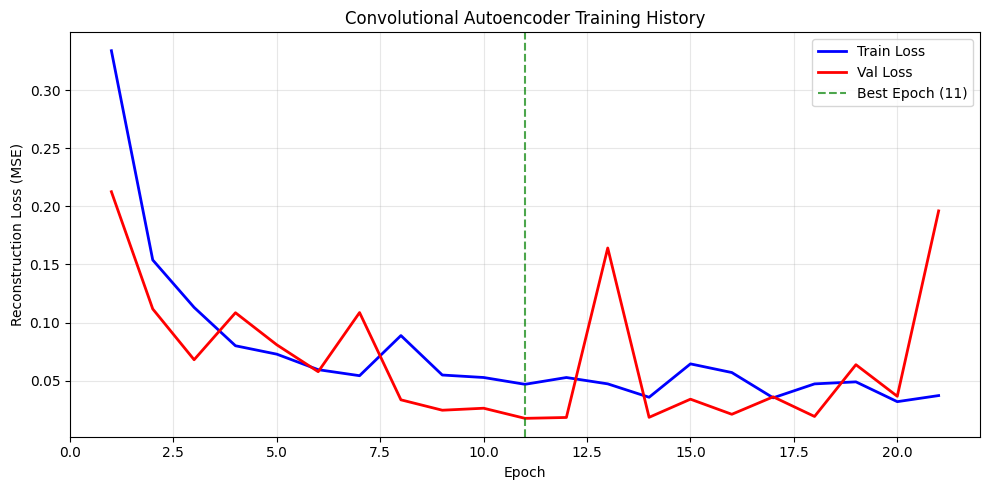

In [12]:
# Training curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax.plot(history['epoch'], history['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Reconstruction Loss (MSE)')
ax.set_title(f'Convolutional Autoencoder Training History{" - QUICK" if QUICK_MODE else ""}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'conv_autoencoder_training_loss{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

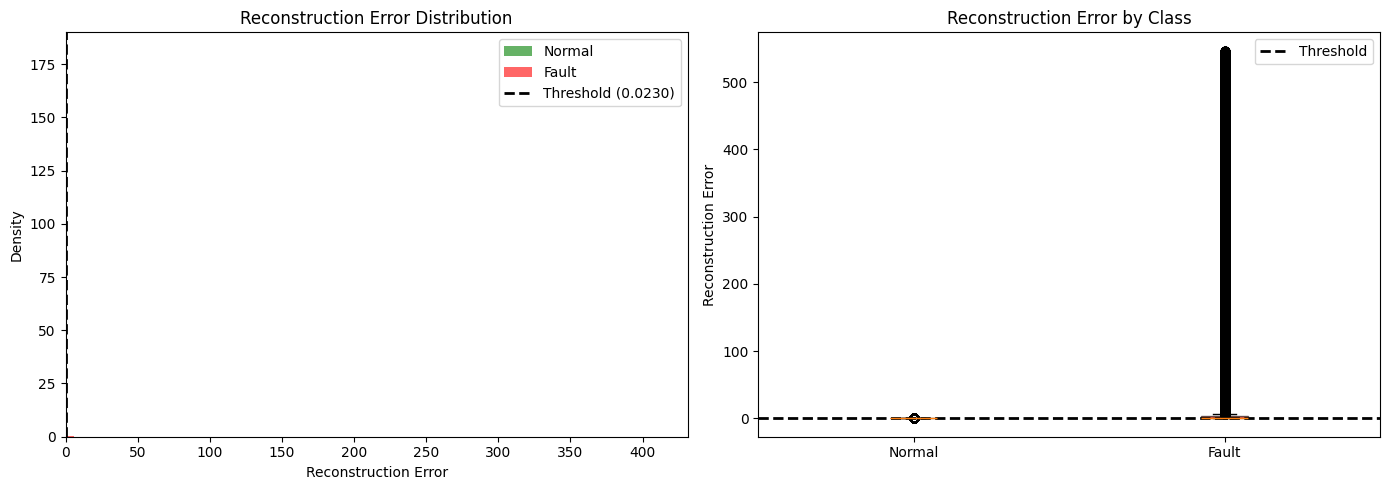

In [13]:
# Reconstruction error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error distribution by class
normal_errors = all_errors[y_test == 0]
fault_errors = all_errors[y_test == 1]

axes[0].hist(normal_errors, bins=100, alpha=0.6, label='Normal', color='green', density=True)
axes[0].hist(fault_errors, bins=100, alpha=0.6, label='Fault', color='red', density=True)
axes[0].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')
axes[0].set_xlabel('Reconstruction Error')
axes[0].set_ylabel('Density')
axes[0].set_title(f'Reconstruction Error Distribution{" - QUICK" if QUICK_MODE else ""}')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(all_errors, 99))

# Box plot
error_data = [normal_errors, fault_errors]
bp = axes[1].boxplot(error_data, labels=['Normal', 'Fault'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('red')
bp['boxes'][1].set_alpha(0.6)
axes[1].axhline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold')
axes[1].set_ylabel('Reconstruction Error')
axes[1].set_title(f'Reconstruction Error by Class{" - QUICK" if QUICK_MODE else ""}')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'conv_autoencoder_error_distribution{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

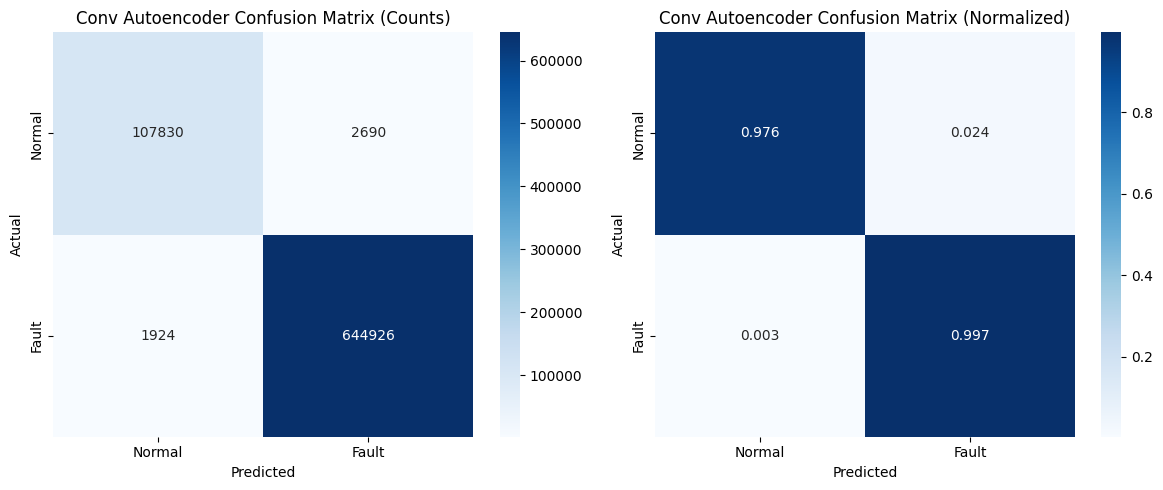

[2026-01-05 14:24:22] ✓ Saved confusion matrix to ../outputs/figures/conv_autoencoder_confusion_matrix.png


In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Conv Autoencoder Confusion Matrix (Counts){" - QUICK" if QUICK_MODE else ""}')

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Conv Autoencoder Confusion Matrix (Normalized){" - QUICK" if QUICK_MODE else ""}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'conv_autoencoder_confusion_matrix{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()
log(f"✓ Saved confusion matrix to {FIGURES_DIR / f'conv_autoencoder_confusion_matrix{MODE_SUFFIX}.png'}")

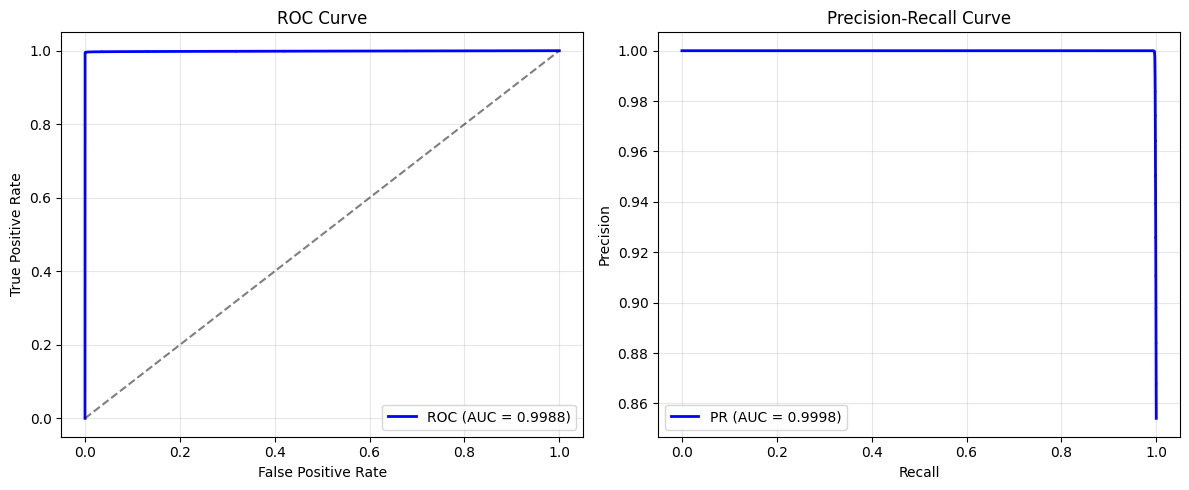

In [15]:
from sklearn.metrics import roc_curve

# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, all_errors)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve{" - QUICK" if QUICK_MODE else ""}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PR curve
axes[1].plot(recall_curve, precision_curve, 'b-', linewidth=2, label=f'PR (AUC = {pr_auc:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve{" - QUICK" if QUICK_MODE else ""}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'conv_autoencoder_roc_pr_curves{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

## Save Results

In [16]:
end_time = time.time()
total_runtime = end_time - start_time

# Compile all metrics
metrics = {
    'model': 'Conv-Autoencoder',
    'task': 'binary',
    'quick_mode': QUICK_MODE,
    'train_fraction': TRAIN_FRACTION,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'test_samples': len(test_dataset),
    'best_epoch': best_epoch,
    'best_val_loss': float(best_val_loss),
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_binary': float(f1_binary),
    'precision': float(precision),
    'recall': float(recall),
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'threshold': float(threshold),
    'threshold_percentile': float(threshold_percentile),
    'per_class_metrics': {
        'Normal': {
            'precision': float(precision_score(y_test, y_pred, pos_label=0)),
            'recall': float(recall_score(y_test, y_pred, pos_label=0)),
            'f1': float(f1_score(y_test, y_pred, pos_label=0))
        },
        'Fault': {
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1_binary)
        }
    },
    'hyperparameters': best_params,
    'epochs_trained': len(history['epoch']),
    'training_time_seconds': float(train_time),
    'total_runtime_seconds': float(total_runtime),
    'random_seed': RANDOM_SEED
}

# Save metrics
with open(METRICS_DIR / f'conv_autoencoder_metrics{MODE_SUFFIX}.json', 'w') as f:
    json.dump(metrics, f, indent=2)
log(f"✓ Saved metrics to {METRICS_DIR / f'conv_autoencoder_metrics{MODE_SUFFIX}.json'}")

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'features': features,
    'hyperparameters': best_params,
    'threshold': threshold,
    'threshold_percentile': threshold_percentile,
    'use_transformer': use_transformer
}, MODEL_DIR / f'conv_autoencoder_final{MODE_SUFFIX}.pt')
log(f"✓ Saved model to {MODEL_DIR / f'conv_autoencoder_final{MODE_SUFFIX}.pt'}")

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(METRICS_DIR / f'conv_autoencoder_confusion_matrix{MODE_SUFFIX}.csv')
log(f"✓ Saved confusion matrix to {METRICS_DIR / f'conv_autoencoder_confusion_matrix{MODE_SUFFIX}.csv'}")

print(f"\n{'='*60}")
log(f"✓ Convolutional Autoencoder Final Training Complete! {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
log(f"Total runtime: {int(total_runtime // 60)}m {int(total_runtime % 60)}s")
log(f"Best epoch: {best_epoch}")
log(f"Test Accuracy: {accuracy:.4f}")
log(f"Test F1 (weighted): {f1_weighted:.4f}")
log(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"{'='*60}")

[2026-01-05 14:24:24] ✓ Saved metrics to ../outputs/metrics/conv_autoencoder_metrics.json
[2026-01-05 14:24:25] ✓ Saved model to ../outputs/models/conv_autoencoder_final.pt
[2026-01-05 14:24:25] ✓ Saved confusion matrix to ../outputs/metrics/conv_autoencoder_confusion_matrix.csv

[2026-01-05 14:24:25] ✓ Convolutional Autoencoder Final Training Complete! 
[2026-01-05 14:24:25] Total runtime: 1m 37s
[2026-01-05 14:24:25] Best epoch: 11
[2026-01-05 14:24:25] Test Accuracy: 0.9939
[2026-01-05 14:24:25] Test F1 (weighted): 0.9939
[2026-01-05 14:24:25] Test ROC-AUC: 0.9988
